## Data and Package Import

In [1]:
from ipynb.fs.full.myFunctions import *   

#error handling
warnings.filterwarnings('ignore')

In [2]:
#insert file path below
file_location=r'C:\Users\csmov\05132021 in vitro training data\FullMasterTri 06022021.xlsx' #location of Excel sheet
#file_location=r'C:\Users\csmov\05132021 in vitro training data\05172021_55_bare\06022021\MasterPulse.xlsx'
sheetName = 'BS NA TriCut' #sheet where data is located

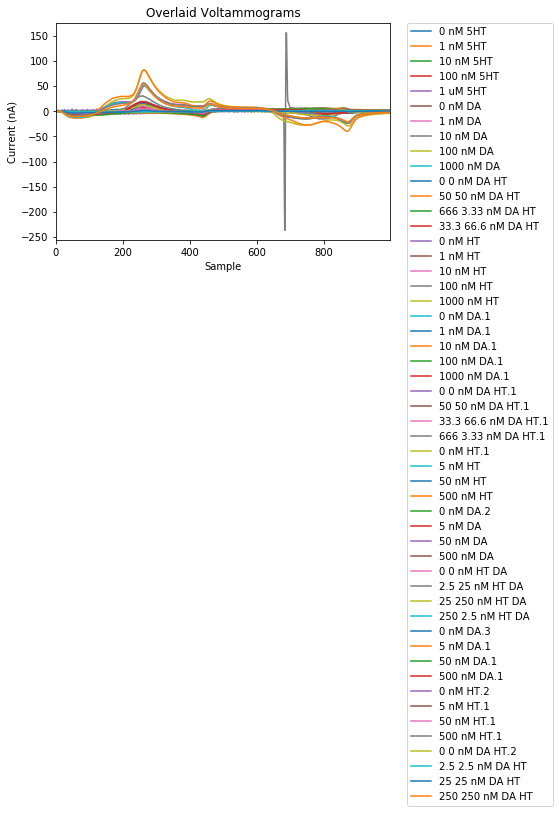

In [3]:
#import data
df_RPV = pd.read_excel(file_location, sheet_name=sheetName) #dataframe for voltammogram response

df_RPV_T = df_RPV.T #transpose to get in correct format for sklearn
df_ConcAll = pd.read_excel(file_location, sheet_name = 'Conc') #dataframe for concentrations of df_RPV responses
df_Samples = pd.DataFrame((list(df_RPV.columns)),columns=['Sample']) #extracts sample code

df_RPV.plot()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel("Sample");
plt.ylabel("Current (nA)");
plt.title("Overlaid Voltammograms");

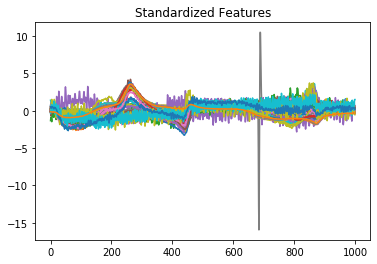

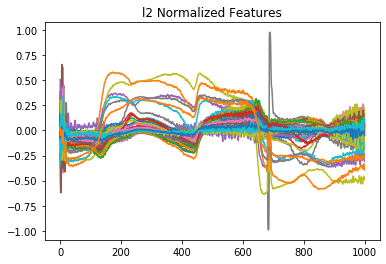

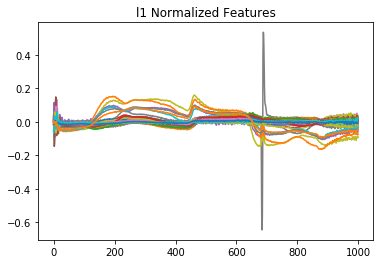

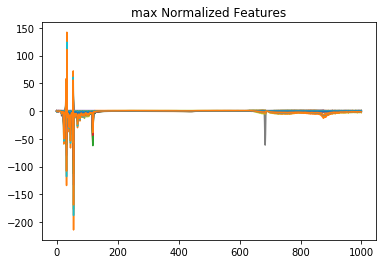

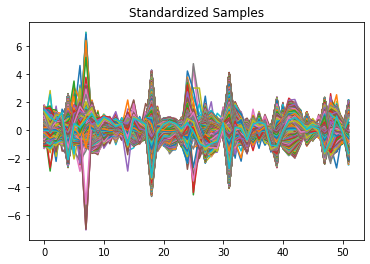

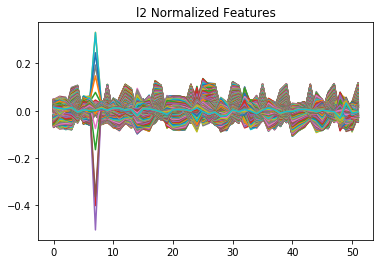

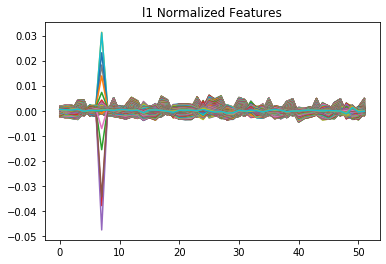

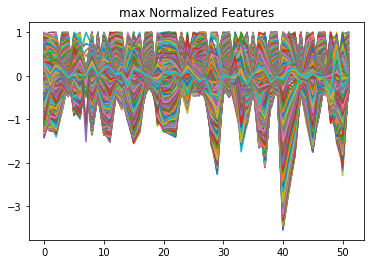

In [4]:
plt.plot((preprocessing.StandardScaler().fit_transform(df_RPV)));
plt.title("Standardized Features")
plt.show()

for myNorm in ['l2','l1','max']:
    plt.plot((preprocessing.Normalizer(norm=myNorm).fit_transform(df_RPV)));
    plt.title(myNorm+' Normalized Features')
    plt.show()
    
plt.plot((preprocessing.StandardScaler().fit_transform(df_RPV_T)));
plt.title("Standardized Samples")
plt.show()

for myNorm in ['l2','l1','max']:
    plt.plot((preprocessing.Normalizer(norm=myNorm).fit_transform(df_RPV_T)));
    plt.title(myNorm+' Normalized Features')
    plt.show()

[0.7539375 0.1280557]
PC1 % Explained Variance: 75.39 
PC2 % Explained Variance: 12.81


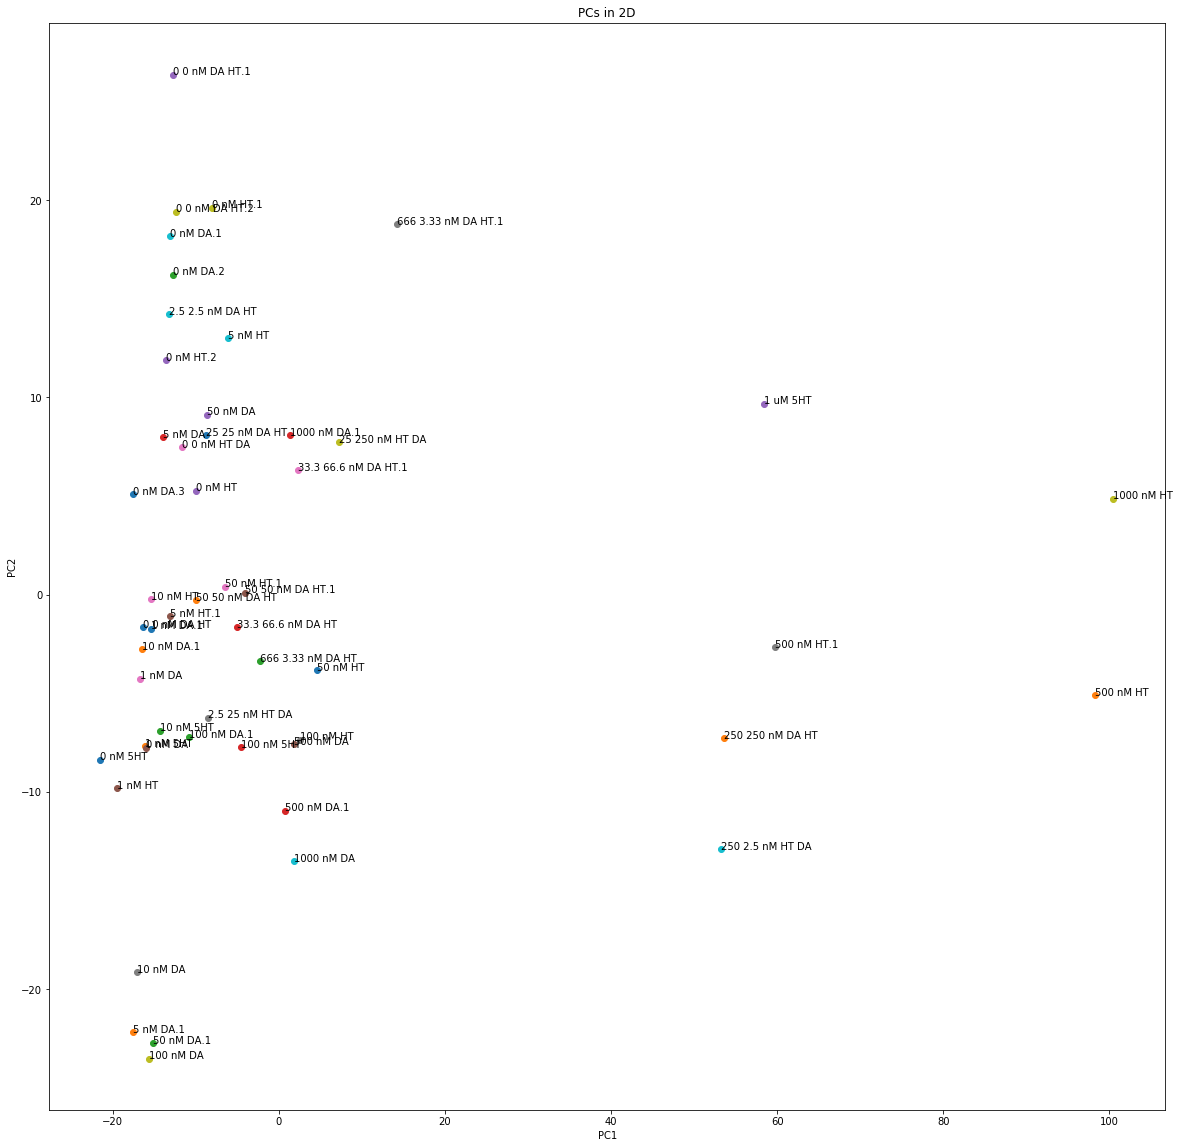

In [5]:
#PCA of X
#ignore warnings; may need to update get_value in future.
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

pca = PCA(n_components = 2) 
principalComponents = pca.fit_transform(scale(df_RPV_T))
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df_Samples], axis = 1)

# plot and label the data in PC space
plt.figure(figsize=(20,20))
for i in range(len(df_Samples)):
    plt.scatter(finalDf.get_value(i,'principal component 1'),finalDf.get_value(i,'principal component 2'))
    plt.annotate(finalDf.get_value(i,"Sample"), (finalDf.get_value(i,'principal component 1'),finalDf.get_value(i,'principal component 2')))
#plt.plot([-1,0,1],[0,0,0],c='k')
#plt.plot([0,0,0],[-1,0,1],c='k')
plt.title("PCs in 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")


print(pca.explained_variance_ratio_)
print("PC1 % Explained Variance:",round(pca.explained_variance_ratio_[0]*100,2), "\nPC2 % Explained Variance:", round(pca.explained_variance_ratio_[1]*100,2))


## Preprocessing and Outlier Removal

In [7]:
removeIndex = 7 #insert index of samples to remove
removeColumns = '10 nM DA' #insert name of samples to remove

try:
    df_ConcAll=df_ConcAll.drop(index=removeIndex)
    df_RPV = df_RPV.drop(columns=removeColumns)
    
except:
    print("Could not find samples listed.")

finally:
    df_RPV_T=df_RPV.T
    df_Samples = pd.DataFrame((list(df_RPV.columns)),columns=['Sample']) #extracts sample code
    list_Samples = df_Samples.values.tolist();

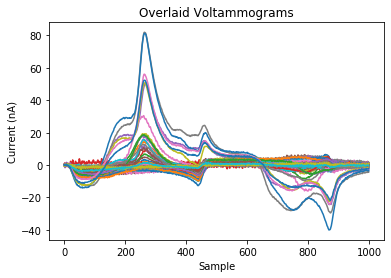

In [8]:
df_ConcDA = df_ConcAll[["DA"]] # contains only dopamine (DA) concentrations
df_ConcHT = df_ConcAll[["HT"]] # contains only serotonin (5HT) concentrations
df_Samples = pd.DataFrame((list(df_RPV.columns)),columns=['Sample']) #extracts sample code

X = df_RPV_T.to_numpy();
X_raw = df_RPV_T.to_numpy();
y = df_ConcAll.to_numpy();
y_DA = df_ConcAll['DA'].to_numpy();
y_5HT = df_ConcAll['HT'].to_numpy();

list_Samples = df_Samples.values.tolist();

plt.plot(X.T);
plt.xlabel("Sample");
plt.ylabel("Current (nA)");
plt.title("Overlaid Voltammograms");

## Signal Processing

### Baseline Correction
by assymetric least squares; see https://stackoverflow.com/questions/29156532/python-baseline-correction-library

In [ ]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve

def baseline_als(y, lam, p, niter=10):
  L = len(y)
  D = sparse.csc_matrix(np.diff(np.eye(L), 2))
  w = np.ones(L)
  for i in range(niter):
    W = sparse.spdiags(w, 0, L, L)
    Z = W + lam * D.dot(D.transpose())
    z = spsolve(Z, w*y)
    w = p * (y > z) + (1-p) * (y < z)
  return z

#set lam b/t 100 to 10^9 and p b/t 0.001 and 0.1

X_raw_bline = np.zeros(np.shape(X.T))
for i in range(len(X)):
    bline=baseline_als(X_raw.T[:,i],100000,0.1)
    X_raw_bline[:,i]=(X_raw.T)[:,i]-bline
    plt.plot(X_raw_bline,label=i)
    plt.legend()
    plt.show

In [9]:
#Hyperparameters
nComponents = 3

#Preprocessing
preProcess = 'Normalize' #'No Scale', 'Scale Features', 'Scale Samples', or 'Normalize'
myNorm = 'l2' #'max', 'l2' or 'l1'

#Cross-validation
cvFolds = 5

#Model
modelChoice = 'PLSR' #'PLSR', 'PCR'

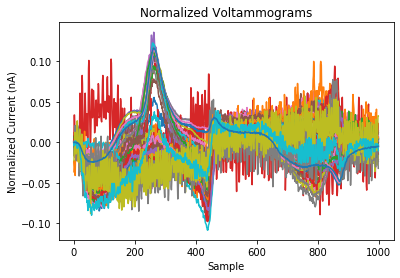

In [10]:

#preprocess

if preProcess == 'Scale Features':
    preProcesser = preprocessing.StandardScaler().fit(X) 
    plt.ylabel("Scaled Current (nA)");
    plt.title("Scaled Feature Voltammograms");
    
if preProcess == 'Normalize':
    preProcesser = preprocessing.Normalizer(norm=myNorm).fit(X) 
    plt.ylabel("Normalized Current (nA)");
    plt.title("Normalized Voltammograms");
    
if preProcess == 'No Scale':
    preProcesser = preprocessing.StandardScaler(with_mean=False,with_std=False).fit(X) 
    plt.ylabel("Scaled Current (nA)");
    plt.title("Non-scaled Voltammograms");
    
if preProcess == 'Scale Samples':
    preProcesser = preprocessing.StandardScaler().fit(X.T)
    plt.ylabel("Scaled Current (nA)");
    plt.title("Scaled Sample Voltammograms");
    
X = preProcesser.transform(X) 
plt.plot(X.T);
plt.xlabel("Sample");


In [ ]:
list(df_RPV.columns)

In [16]:
#electrode colormap

cmap_electrode = {'0 nM HT':'r',
 '1 nM HT':'r',
 '10 nM HT':'r',
 '100 nM HT':'r',
 '1000 nM HT':'r',
 '0 nM DA':'r',
 '1 nM DA':'r',
 '10 nM DA':'r',                 
 '100 nM DA':'r',
 '1000 nM DA':'r',
 '0 0 nM DA HT':'r',
 '50 50 nM DA HT':'r',
 '666 3.33 nM DA HT':'r',
 '33.3 66.6 nM DA HT':'r',
 '0 nM HT.1':'b',
 '1 nM HT.1':'b',
 '10 nM HT.1':'b',
 '100 nM HT.1':'b',
 '1000 nM HT.1':'b',
 '0 nM DA.1':'b',
 '1 nM DA.1':'b',
 '10 nM DA.1':'b',
 '100 nM DA.1':'b',
 '1000 nM DA.1':'b',
 '0 0 nM DA HT.1':'b',
 '50 50 nM DA HT.1':'b',
 '666 3.33 nM DA HT.1':'b',
 '33.3 66.6 nM DA HT.1':'b',
 '0 nM HT.2':'g',
 '5 nM HT':'g',
 '50 nM HT':'g',
 '500 nM HT':'g',
 '0 0 nM HT DA':'g',
 '2.5 25 HT DA':'g',
 '25 250 nM HT DA':'g',
 '250 2.5 nM HT DA':'g',
 '0 nM HT.3':'k',
 '5 nM HT.1':'k',
 '50 nM HT.1':'k',
 '500 nM HT.1':'k',
 '0 nM DA.2':'k',
 '5 nM DA':'k',
 '50 nM DA':'k',
 '500 nM DA':'k',
 '0 nM DA HT ':'k',
 '2.5 2.5 nM DA HT':'k',
 '25 25 nM DA HT':'k',
 '250 250 nM DA HT':'k'}

In [ ]:
assert(len(cmap_electrode)==len(list(df_RPV.columns)))

PC1 % Explained Variance: 56.47 
PC2 % Explained Variance: 43.53


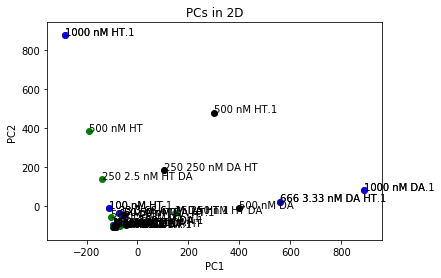

In [43]:
#PCA of Y
#ignore warnings; may need to update get_value in future.
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

pca = PCA(n_components = 2) 
principalComponents = pca.fit_transform(y)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df_Samples], axis = 1)

# plot and label the data in PC space
for i in range(len(df_Samples)):
    plt.scatter(finalDf.get_value(i,'principal component 1'),finalDf.get_value(i,'principal component 2'),color=cmap_electrode[finalDf.get_value(i,"Sample")])
    plt.annotate(finalDf.get_value(i,"Sample"), (finalDf.get_value(i,'principal component 1'),finalDf.get_value(i,'principal component 2')))
plt.plot([-5,0,5],[0,0,0],c='k')
plt.plot([0,0,0],[-3,0,3],c='k')
plt.title("PCs in 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")

print("PC1 % Explained Variance:", round(pca.explained_variance_ratio_[0]*100,2), "\nPC2 % Explained Variance:", round(pca.explained_variance_ratio_[1]*100,2))

In [11]:
#PCA of X
#ignore warnings; may need to update get_value in future.
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

pca = PCA(n_components = 2) 
principalComponents = pca.fit_transform((X))
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df_Samples], axis = 1)

# plot and label the data in PC space
plt.figure(figsize=(10,10))
for i in range(len(df_Samples)):
    plt.scatter(finalDf.get_value(i,'principal component 1'),finalDf.get_value(i,'principal component 2'),color=cmap_electrode[finalDf.get_value(i,"Sample")])
    plt.annotate(finalDf.get_value(i,"Sample"), (finalDf.get_value(i,'principal component 1'),finalDf.get_value(i,'principal component 2')))
#plt.plot([-1,0,1],[0,0,0],c='k')
#plt.plot([0,0,0],[-1,0,1],c='k')
plt.title("PCs in 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")

print("PC1 % Explained Variance:",round(pca.explained_variance_ratio_[0]*100,2), "\nPC2 % Explained Variance:", round(pca.explained_variance_ratio_[1]*100,2))

pca = PCA(n_components = 0.95) 
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
print("Num Components for 95% Variance Explained:", pca.n_components_)
print("PC1 % Explained Variance:", np.round(cumsum,3)[0],"\nPC2 % Explained Variance:", np.round(cumsum,3)[1])

NameError: name 'cmap_electrode' is not defined

<Figure size 720x720 with 0 Axes>

    Number Components  Variance Explained (%), All
0                   1                         2.81
1                   2                        10.56
2                   3                        25.98
3                   4                        40.66
4                   5                        62.30
5                   6                        77.51
6                   7                        80.70
7                   8                        86.35
8                   9                        88.19
9                  10                        91.10
10                 11                        93.79
11                 12                        94.73
12                 13                        95.48
13                 14                        95.98
14                 15                        96.99
15                 16                        97.75
16                 17                        98.57
17                 18                        99.18
18                 19          

([<matplotlib.axis.XTick at 0x224fa61b2c8>,
 <a list of 3 Text xticklabel objects>)

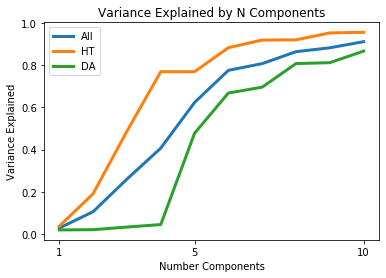

In [45]:
var_exp_DA = np.zeros(len(df_RPV_T))
var_exp_HT = np.zeros(len(df_RPV_T))
var_exp_All = np.zeros(len(df_RPV_T))
i_values = np.arange(1,len(df_RPV_T)+1)

for i in i_values:
    if modelChoice == 'PLSR':
        myModel = make_pipeline(preProcesser, PLSRegression(n_components=i,scale=False))
        myModel.fit_transform(X, y)
    if modelChoice == 'PCR':
        myModel = make_pipeline(preProcesser, PCA(n_components=i), LinearRegression()) 
        myModel.fit(X, y)
    y_pred = myModel.predict(X)
    var_exp_DA[i-1] = r2_score(y,y_pred,multioutput='raw_values')[0]
    var_exp_HT[i-1] = r2_score(y,y_pred,multioutput='raw_values')[1]
    var_exp_All[i-1] = r2_score(y,y_pred)

df_var_exp_All=pd.DataFrame({"Number Components": i_values, "Variance Explained (%), All": np.round(100*var_exp_All,2)})
#df_var_exp_All.to_pickle('df_var_exp_All_'+modelChoice+'_'+preProcess+'_'+myNorm+'_'+sheetName+'_'+str(nComponents))
print(df_var_exp_All,'\n');
df_var_exp_DA=pd.DataFrame({"Number Components": i_values, "Variance Explained (%), DA": np.round(100*var_exp_DA,2)})
#df_var_exp_DA.to_pickle('df_var_exp_DA_'+modelChoice+'_'+preProcess+'_'+myNorm+'_'+sheetName+'_'+str(nComponents))
print(df_var_exp_DA,'\n');
df_var_exp_HT=pd.DataFrame({"Number Components": i_values, "Variance Explained (%), HT": np.round(100*var_exp_HT,2)})
#df_var_exp_HT.to_pickle('df_var_exp_HT_'+modelChoice+'_'+preProcess+'_'+myNorm+'_'+sheetName+'_'+str(nComponents))
print(df_var_exp_HT);

plt.plot(i_values[0:10],var_exp_All[0:10],label='All',linewidth=3);
plt.plot(i_values[0:10],var_exp_HT[0:10],label="HT",linewidth=3);
plt.plot(i_values[0:10],var_exp_DA[0:10],label='DA',linewidth=3);
plt.legend()
plt.title("Variance Explained by N Components");
plt.xlabel("Number Components");
plt.ylabel("Variance Explained");
plt.xticks([1,5,10])

In [46]:
#NEW CV ATTEMPT
#X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, 
#                                                   stratify=y,random_state=1)

#FOR NOW, USE LOOCV
#use 5 or 10-fold if enough data.
#use greater or LOOCV (since small data set)
#For instance, experiments by Ron Kohavi on various real-world datasets
#suggest that 10-fold cross-validation offers the best tradeoff between bias and
#variance (A Study of Cross-Validation and Bootstrap for Accuracy Estimation and Model
#Selection, Kohavi, Ron, International Joint Conference on Artificial Intelligence (IJCAI),
#14 (12): 1137-43, 1995).

#In future; go for stratified k-fold

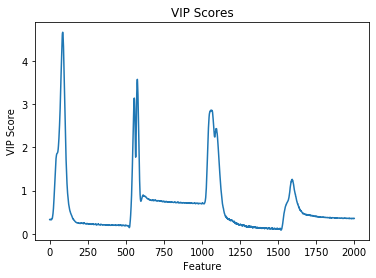

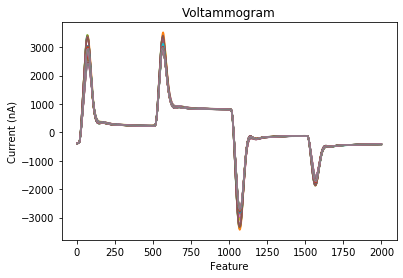

Number Features with VIP > or = 1: 269


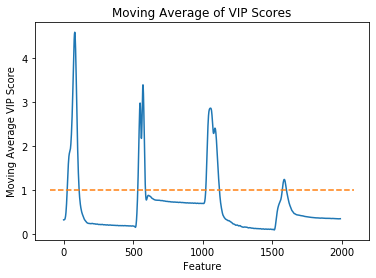

In [47]:
if modelChoice == 'PLSR':
    PLSRmodel=PLSRegression(n_components=nComponents,scale=False) #TODO
    PLSRmodel.fit_transform(X,y)
    vipPLSR = vip(PLSRmodel)
    plt.plot(vip(PLSRmodel))
    plt.xlabel("Feature")
    plt.ylabel('VIP Score')
    plt.title('VIP Scores')
    plt.show()
    plt.plot(df_RPV)
    plt.xlabel("Feature")
    plt.ylabel('Current (nA)')
    plt.title('Voltammogram')
    plt.show()

    countOver1 = 0
    for i in range(len(vipPLSR)):
        if vipPLSR[i] >= 1:
            countOver1 += 1

    print('Number Features with VIP > or = 1:',countOver1)

    plt.plot(moving_average(vipPLSR,n=10))
    plt.xlabel("Feature")
    plt.ylabel('Moving Average VIP Score')
    plt.title('Moving Average of VIP Scores')
    abline(0,1)

In [48]:
if preProcess == 'Scale Features' and modelChoice == 'PLSR':
    param_grid = [
    {'plsregression__n_components': range(len(df_RPV_T[2:10])),'standardscaler__with_mean': [True,False],
     'standardscaler__with_std': [True,False]}]

if preProcess == 'Scale Features' and modelChoice == 'PCR':
    param_grid = [
    {'pca__n_components': range(len(df_RPV_T[2:10])),'standardscaler__with_mean': [True,False],
     'standardscaler__with_std': [True,False]}]
    
if preProcess == 'No Scale' and modelChoice == 'PLSR':
    param_grid = [
    {'plsregression__n_components': range(len(df_RPV_T[2:10]))}]
    
if preProcess == 'No Scale' and modelChoice == 'PCR':
    param_grid = [
    {'pca__n_components': range(len(df_RPV_T[2:10])),'linearregression__normalize':[True,False]}] 
    
if preProcess == 'Scale Samples' and modelChoice == 'PLSR':
    param_grid = [
    {'plsregression__n_components': range(len(df_RPV_T[2:10])), 'plsregression__scale':[True, False]}]

if preProcess == 'Scale Samples' and modelChoice == 'PCR':
    param_grid = [
    {'pca__n_components': range(len(df_RPV_T[2:10])), 'linearregression__normalize':[True, False]}]

if preProcess == 'Normalize' and modelChoice == 'PLSR':
    param_grid = [
    {'plsregression__n_components': range(len(df_RPV_T[2:10])),'normalizer__norm': ['l1', 'l2', 'max']}]

if preProcess == 'Normalize' and modelChoice == 'PCR':
    param_grid = [
    {'pca__n_components': range(len(df_RPV_T[2:10])),'normalizer__norm': ['l1', 'l2', 'max']}]

if modelChoice == 'PLSR':
    GSmodel = make_pipeline(preProcesser, PLSRegression(scale=False)) 
if modelChoice == 'PCR':
    GSmodel = make_pipeline(preProcesser, PCA(), LinearRegression())
    
grid_search = GridSearchCV(GSmodel, param_grid, cv=cvFolds,
        scoring='neg_mean_squared_error',
        return_train_score=True)

grid_search.fit(X,y);

print(grid_search.best_params_, grid_search.best_estimator_)

{'normalizer__norm': 'l2', 'plsregression__n_components': 6} Pipeline(memory=None,
         steps=[('normalizer', Normalizer(copy=True, norm='l2')),
                ('plsregression',
                 PLSRegression(copy=True, max_iter=500, n_components=6,
                               scale=False, tol=1e-06))],
         verbose=False)


14
1
2
3
4
5
6
7
8
9
10
   Number Components  Variance Explained (%), All CV
0                  1                          -49.78
1                  2                          -29.07
2                  3                          -12.28
3                  4                           14.54
4                  5                           18.98
5                  6                           19.61
6                  7                           28.35
7                  8                           35.57
8                  9                           36.03
9                 10                           35.72 

   Number Components  Variance Explained (%), DA CV
0                  1                         -51.97
1                  2                           0.67
2                  3                          13.82
3                  4                          41.98
4                  5                          35.62
5                  6                          39.62
6                  7       

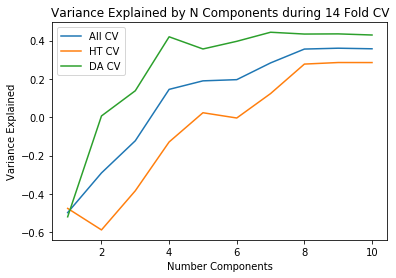

In [22]:
    cvFold=len(df_RPV_T)
    i_values = np.arange(1,11)
    CV_var_exp_DA = np.zeros(len(i_values))
    CV_var_exp_HT = np.zeros(len(i_values))
    CV_var_exp_All = np.zeros(len(i_values))
    print(cvFold)
    for i in (i_values):
        print(i)
        if modelChoice == 'PLSR':
            myModel = make_pipeline(preProcesser, PLSRegression(n_components=i,scale=False))
        if modelChoice == 'PCR':
            myModel = make_pipeline(preProcesser, PCA(n_components=i), LinearRegression())  
        y_train_pred = cross_val_predict(myModel, X_raw, y, cv=cvFold)
        CV_var_exp_DA[i-1] = r2_score(y_DA,y_train_pred[:,0])
        CV_var_exp_HT[i-1] = r2_score(y_5HT,y_train_pred[:,1])
        CV_var_exp_All[i-1] = r2_score(y,y_train_pred)
    df_CV_var_exp_All=pd.DataFrame({"Number Components": i_values, 
                                    "Variance Explained (%), All CV": np.round(100*CV_var_exp_All,2)})
    if cvFold == 18:   
        df_CV_var_exp_All.to_pickle('df_CV_var_exp_All_'+modelChoice+'_'+preProcess+'_'+myNorm+'_'+sheetName
                                    +'_'+str(nComponents)+'_comp'+str(cvFold)+'folds')
    print(df_CV_var_exp_All,'\n');
    df_CV_var_exp_DA=pd.DataFrame({"Number Components": i_values, "Variance Explained (%), DA CV": np.round(100*CV_var_exp_DA,2)})
    if cvFold == 18:
        df_CV_var_exp_DA.to_pickle('df_CV_var_exp_DA_'+modelChoice+'_'+preProcess+'_'+myNorm+'_'+sheetName
                                    +'_'+str(nComponents)+'_comp'+str(cvFold)+'folds')
    print(df_CV_var_exp_DA,'\n');
    df_CV_var_exp_HT=pd.DataFrame({"Number Components": i_values, "Variance Explained (%), HT CV": np.round(100*CV_var_exp_HT,2)})
    if cvFold == 18:
        df_CV_var_exp_HT.to_pickle('df_CV_var_exp_HT_'+modelChoice+'_'+preProcess+'_'+myNorm+'_'+sheetName
                                    +'_'+str(nComponents)+'_comp'+str(cvFold)+'folds')
    print(df_CV_var_exp_HT);
    plt.plot(i_values,CV_var_exp_All,label='All CV');
    plt.plot(i_values,CV_var_exp_HT,label="HT CV");
    plt.plot(i_values,CV_var_exp_DA,label='DA CV');
    plt.legend()
    plt.title("Variance Explained by N Components during "+str(cvFold)+" Fold CV");
    plt.xlabel("Number Components");
    plt.ylabel("Variance Explained");
    plt.show()

ValueError: x and y must have same first dimension, but have shapes (48,) and (14,)

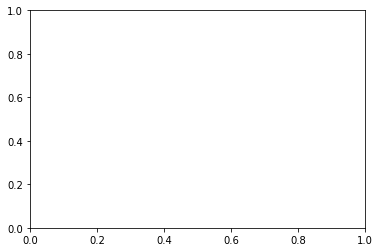

In [49]:
plt.plot(i_values,CV_var_exp_All,label='Q2Y',linewidth=3,linestyle='dashed',marker='o');
print(i_values)
print(CV_var_exp_All)
print(var_exp_All)
plt.plot(i_values,var_exp_All[0:10],label='R2Y',linewidth=3,marker='^');
plt.legend(loc=4,fontsize='large')
plt.xticks([1,5,10,15,20],fontsize=12)
plt.xlabel("Number Components",fontsize=15);
plt.ylabel("Variance Explained",fontsize=15);
plt.yticks(fontsize=12)
fig = plt.gcf()
fig.set_size_inches(6, 5)
plt.show()

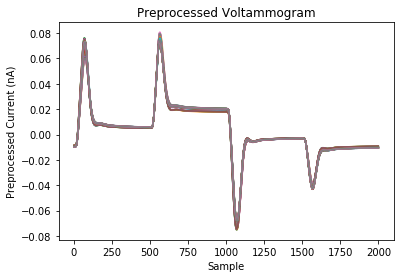

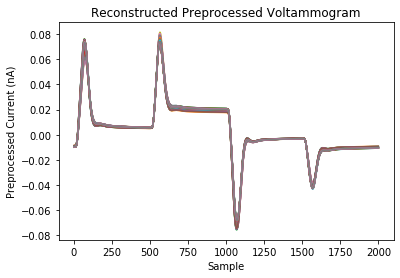

Reconstruction Error (%): 4.5


In [50]:
#R2X
if modelChoice == 'PCR':
    pca = PCA(n_components=nComponents);
    X_reduced = pca.fit_transform(X);
    X_recovered = pca.inverse_transform(X_reduced);
    
if modelChoice == 'PLSR':
    plsr = PLSRegression(n_components=nComponents,scale=False);
    X_reduced = plsr.fit_transform(X,y);
    X_recovered = plsr.inverse_transform(plsr.x_scores_);
    
plt.plot(X.T);
plt.xlabel('Sample')
plt.ylabel('Preprocessed Current (nA)')
plt.title('Preprocessed Voltammogram')
plt.show();
plt.plot((X_recovered).T);
plt.xlabel('Sample')
plt.ylabel('Preprocessed Current (nA)')
plt.title('Reconstructed Preprocessed Voltammogram')
plt.show()

if preProcess != 'Normalize':
    plt.plot((preProcesser.inverse_transform(X)).T);
    plt.xlabel('Sample')
    plt.ylabel('Current (nA)')
    plt.title('Voltammogram')
    plt.show();
    plt.plot((preProcesser.inverse_transform(X_recovered)).T);
    plt.xlabel('Sample')
    plt.ylabel('Current (nA)')
    plt.title('Reconstructed Voltammogram')
    plt.show()

print("Reconstruction Error (%):", 100*round(1-r2_score(X,X_recovered),4))

    Predicted DA  Actual DA  Predicted 5HT  Actual 5HT
0          25.34        0.0          13.70        0.00
1         -36.07        0.0          81.56        1.00
2         -72.68        0.0          50.58       10.00
3         -15.86        0.0         159.17      100.00
4          -0.94        0.0         635.08     1000.00
5         -33.94        0.0          62.31        0.00
6         -30.85        1.0          68.10        0.00
7          48.71      100.0          21.18        0.00
8         709.92     1000.0           7.68        0.00
9         -29.19        0.0          92.52        0.00
10        -38.94       50.0           9.99       50.00
11        625.50      666.0           2.32        3.33
12         86.61       33.3          54.55       66.60
13         12.64        0.0          55.02        0.00
14        110.63        0.0           6.54        1.00
15         57.15        0.0         -44.27       10.00
16        139.29        0.0         219.19      100.00
17        

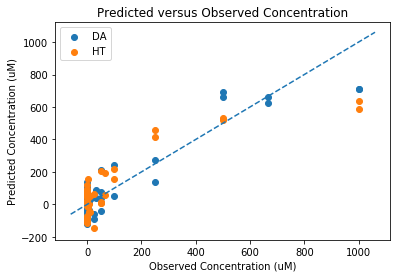

In [14]:
nComponents=6
if modelChoice == 'PLSR':
    myModel = make_pipeline(preProcesser, PLSRegression(n_components=nComponents,scale=False))
    myModel.fit_transform(X, y)
if modelChoice == 'PCR':
    myModel = make_pipeline(preProcesser, PCA(n_components=nComponents), LinearRegression()) 
    myModel.fit(X, y)

#R2Y
if modelChoice =='PCR':
    myModel.fit(X_raw,y)
if modelChoice =='PLSR':
    myModel.fit_transform(X_raw,y)
y_pred = myModel.predict(X_raw)
df_PredConc=pd.DataFrame({"Predicted DA": np.round(y_pred[:,0],2),'Actual DA':np.round(y[:,0],2),
                     "Predicted 5HT": np.round(y_pred[:,1],2),'Actual 5HT':np.round(y[:,1],2)})
print(df_PredConc)

r2_score_DA = r2_score(y_DA,y_pred[:,0],multioutput='raw_values')
r2_score_5HT = r2_score(y_5HT,y_pred[:,1],multioutput='raw_values')
print('R2Y DA:',(100*np.round(r2_score_DA,4)))
print('R2Y 5HT:', (100*np.round(r2_score_5HT,4)))
print('R2Y All:',100*np.round(r2_score(y,y_pred),4))

plt.scatter(df_ConcAll["DA"],y_pred[:,0], label="DA");
plt.scatter(df_ConcAll["HT"],y_pred[:,1], label="HT");
plt.xlabel('Observed Concentration (uM)')
plt.ylabel('Predicted Concentration (uM)')
plt.title("Predicted versus Observed Concentration")
abline(1,0)
plt.plot();
plt.legend();

#debug code
R2Y_DA = 1-(np.sum((y_pred[:,0]-y_DA)**2))/(np.sum((y_DA-np.mean(y_DA))**2))
R2Y_5HT = 1-(np.sum((y_pred[:,1]-y_5HT)**2))/(np.sum((y_5HT-np.mean(y_5HT))**2))
assert R2Y_DA == r2_score_DA
assert R2Y_5HT == r2_score_5HT

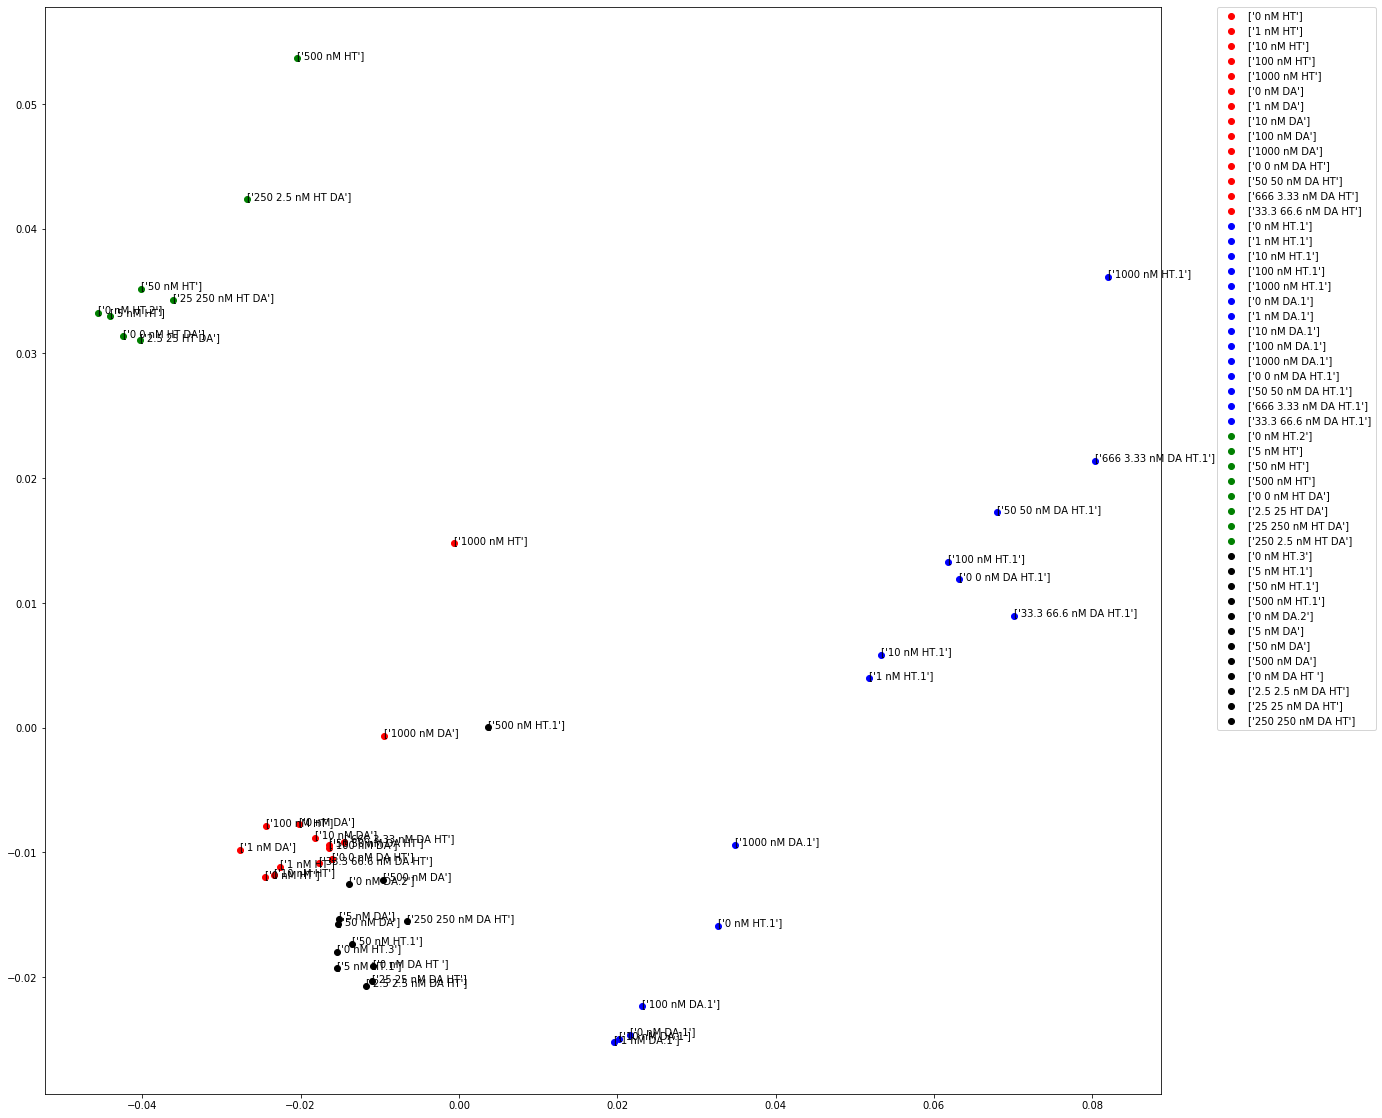

No handles with labels found to put in legend.


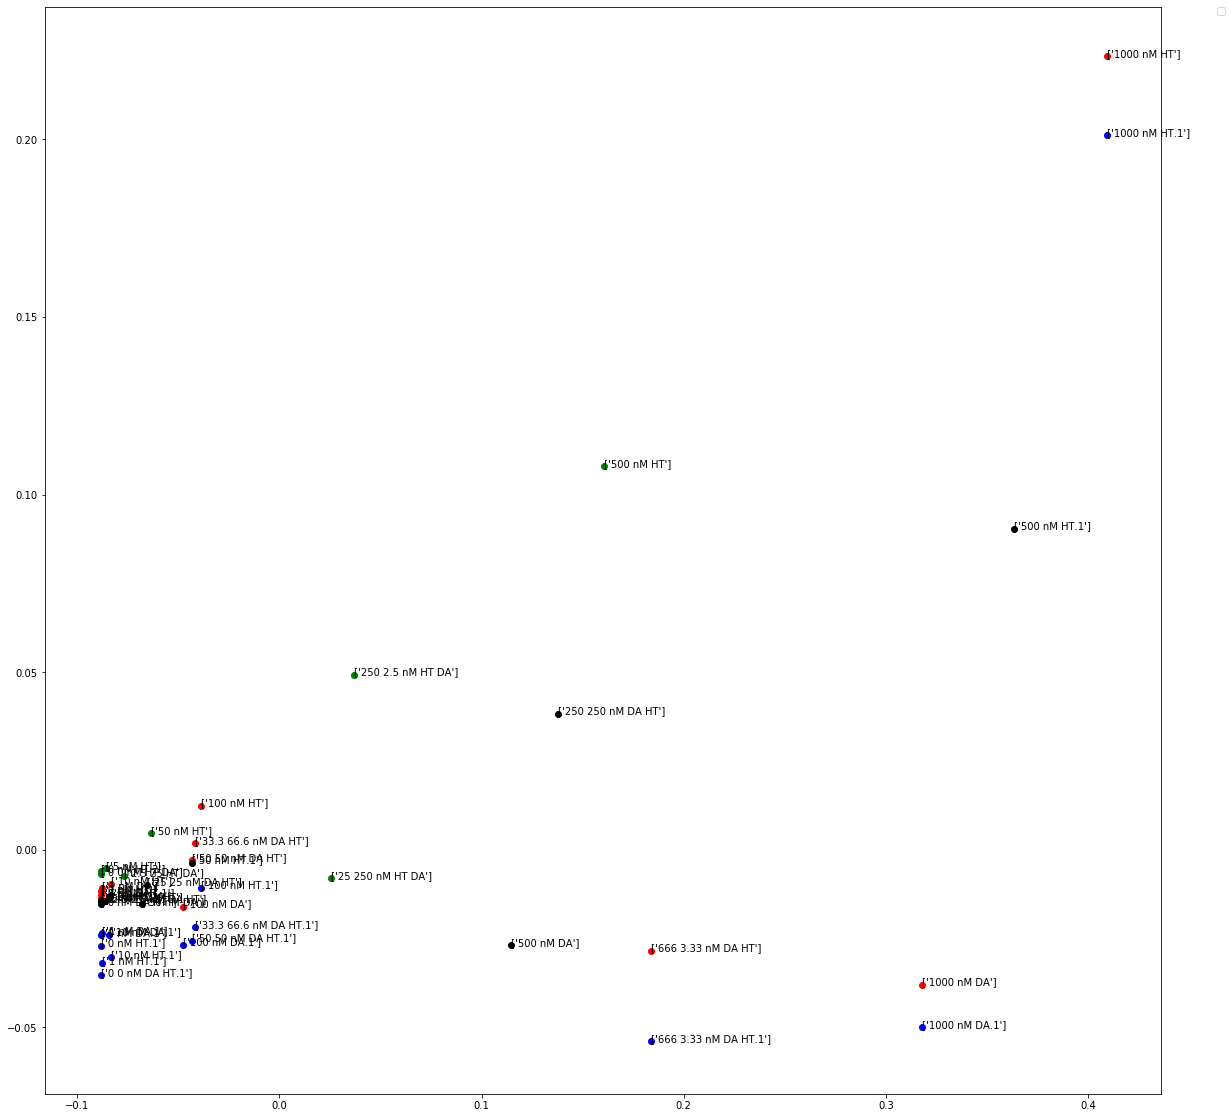

In [52]:
xScores=(myModel['plsregression'].x_scores_)
yScores=(myModel['plsregression'].y_scores_)

plt.figure(figsize=(20,20))
for i in range(len(X)):
    plt.scatter(xScores[i][0],xScores[i][1],label=list_Samples[i],color=cmap_electrode[finalDf.get_value(i,"Sample")])
    plt.annotate(list_Samples[i],(xScores[i][0],xScores[i][1]))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

plt.figure(figsize=(20,20))
for i in range(len(X)):
    plt.scatter(yScores[i][0],yScores[i][1],color=cmap_electrode[finalDf.get_value(i,"Sample")])
    plt.annotate(list_Samples[i],(yScores[i][0],yScores[i][1]))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [53]:
print(len(range(len(CV_var_exp_All)+1)[1:])
     )

14


In [13]:
CV_var_exp_DA = np.zeros(len(df_RPV_T))
CV_var_exp_HT = np.zeros(len(df_RPV_T))
CV_var_exp_All = np.zeros(len(df_RPV_T))
i_values = range(len(CV_var_exp_All)+1)[1:]

for i in (range(len(CV_var_exp_All))[1:]):
    if modelChoice == 'PLSR':
        myModel = make_pipeline(preProcesser, PLSRegression(n_components=i,scale=False))
    if modelChoice == 'PCR':
        myModel = make_pipeline(preProcesser, PCA(n_components=i), LinearRegression())  
    #cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    y_train_pred = cross_val_predict(myModel, X_raw, y,cv=14)
    CV_var_exp_DA[i-1] = r2_score(y_DA,y_train_pred[:,0])
    CV_var_exp_HT[i-1] = r2_score(y_5HT,y_train_pred[:,1])
    CV_var_exp_All[i-1] = r2_score(y,y_train_pred)

df_CV_var_exp_All=pd.DataFrame({"Number Components": i_values, 
                                "Variance Explained (%), All CV": np.round(100*CV_var_exp_All,2)})
print(df_CV_var_exp_All,'\n');
df_CV_var_exp_DA=pd.DataFrame({"Number Components": i_values, 
                               "Variance Explained (%), DA CV": np.round(100*CV_var_exp_DA,2)})
print(df_CV_var_exp_DA,'\n');
df_CV_var_exp_HT=pd.DataFrame({"Number Components": i_values, 
                               "Variance Explained (%), HT CV": np.round(100*CV_var_exp_HT,2)})
print(df_CV_var_exp_HT);
plt.plot(i_values,CV_var_exp_All,label='All CV');
plt.plot(i_values,CV_var_exp_HT,label="HT CV");
plt.plot(i_values,CV_var_exp_DA,label='DA CV');
plt.legend()
plt.title("Variance Explained by N Components during "+str(cvFold)+" Fold CV");
plt.xlabel("Number Components");
plt.ylabel("Variance Explained");
plt.show()

KeyboardInterrupt: 

# In Vivo Analysis

Training 2 component model...
[8, 2, 7, 28, 6, 17, 'olivia', 'sabrina', 'josh', 'click', 'clack', 'pow pow']
[-145.7049  -50.7867   71.7262   44.2209  232.917   394.3435   57.9234
  169.7905  133.6131  -53.4249   11.7301   51.0415]
[ 320.5044   29.3319   77.8473  -73.2276 -122.9458  167.2835    1.05
  -69.2777  350.6273   17.244   -15.39     35.2825]


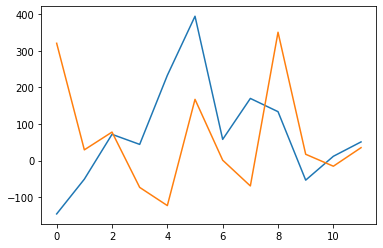

Training 3 component model...
[8, 2, 7, 28, 6, 17, 'olivia', 'sabrina', 'josh', 'click', 'clack', 'pow pow']
[ -73.7067  -57.0304  -97.3603   37.5616  276.0717  641.6046    3.1169
   80.0889   32.75    -30.9856  -57.5576 -122.0977]
[ 288.935    32.0696  151.9874  -70.3076 -141.868    58.8657   25.0813
  -29.9459  394.8533    7.4049   14.991   111.1997]


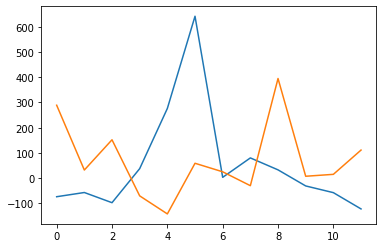

Training 4 component model...
[8, 2, 7, 28, 6, 17, 'olivia', 'sabrina', 'josh', 'click', 'clack', 'pow pow']
[ -31.1477  -27.7683  -54.2      25.2206  310.8615  659.7376  -87.0101
   64.1013   26.41      4.855   -15.8609 -129.8848]
[ 308.6278   45.6097  171.9585  -76.018  -125.7701   67.2562  -16.6222
  -37.3436  391.9197   23.9891   34.2848  107.5964]


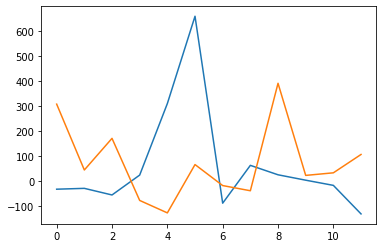

Training 5 component model...
[8, 2, 7, 28, 6, 17, 'olivia', 'sabrina', 'josh', 'click', 'clack', 'pow pow']
[ -41.5326  -30.2073  -73.8339   49.8334  312.9596  706.9216  -56.885
   53.1504   24.6826  -24.7709  -24.8663 -142.8225]
[ 295.6205   42.5548  147.3666  -45.1902 -123.1422  126.3549   21.1101
  -51.0598  389.7561  -13.1179   23.0054   91.3918]


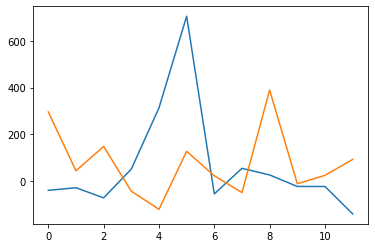

Training 6 component model...
[8, 2, 7, 28, 6, 17, 'olivia', 'sabrina', 'josh', 'click', 'clack', 'pow pow']
[ -37.3017  -35.4903  -65.4606   43.1505  295.3184  707.8427  -47.1018
   37.8388   15.5028   -4.9518  -22.004  -110.3141]
[279.8515  62.2449 116.1579 -20.282  -57.3913 122.922  -15.3531   6.0086
 423.9705 -86.9862  12.3373 -29.7711]


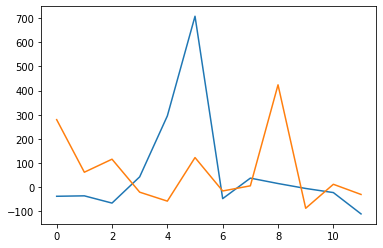

Training 7 component model...
[8, 2, 7, 28, 6, 17, 'olivia', 'sabrina', 'josh', 'click', 'clack', 'pow pow']
[ -52.9967  -30.2257  -65.5588   43.1467  310.0741  713.4464  -41.5764
   74.7229   20.1051  -52.8909  -28.2795 -114.319 ]
[306.5883  53.2766 116.3253 -20.2756 -82.528  113.3759 -24.7658 -56.8244
 416.1303  -5.3208  23.0277 -22.9487]


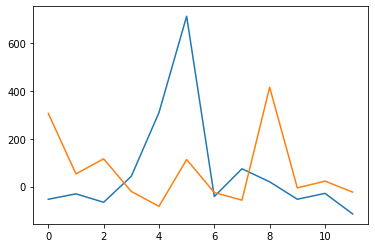

Training 8 component model...
[8, 2, 7, 28, 6, 17, 'olivia', 'sabrina', 'josh', 'click', 'clack', 'pow pow']
[  6.1806   7.591  -12.9125  43.6629 293.0738 735.2614   6.4136  81.3554
   7.8467 -20.7669   2.2793 -93.5817]
[329.8875  68.1658 137.0532 -20.0723 -89.2213 121.9649  -5.8712 -54.2131
 411.3039   7.327   35.0593 -14.7841]


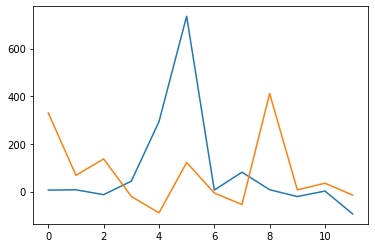

Training 9 component model...
[8, 2, 7, 28, 6, 17, 'olivia', 'sabrina', 'josh', 'click', 'clack', 'pow pow']
[ 9.220900e+00  4.512190e+01 -1.356880e+01  5.213300e+01  3.039624e+02
  7.309989e+02  1.329680e+01  9.833650e+01  1.432030e+01 -4.114720e+01
  3.080000e-02 -1.015981e+02]
[ 321.9302  -30.0628  138.7709  -42.2409 -117.7196  133.121   -23.8865
  -98.6571  394.361    60.6677   40.9442    6.197 ]


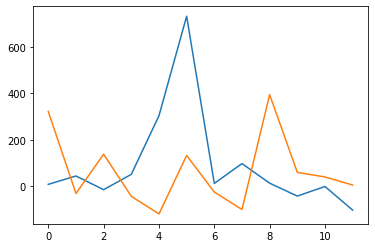

Training 10 component model...
[8, 2, 7, 28, 6, 17, 'olivia', 'sabrina', 'josh', 'click', 'clack', 'pow pow']
[  16.4667   59.4248  -14.071    52.8944  308.9272  732.2206    9.1654
  104.0366   18.3692  -44.2394   -0.7413 -105.4941]
[ 241.6173 -188.5973  144.3375  -50.6799 -172.7509  119.58     21.9062
 -161.8384  349.4825   94.9419   49.5028   49.3807]


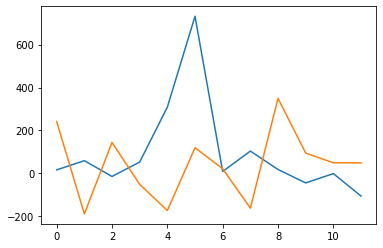

Training Complete!


In [15]:
compRange=[2,3,4,5,6,7,8,9,10]
for x in compRange:
    print('Training ' + str(x) + ' component model...')
    j=0
    if modelChoice == 'PLSR':
        myModel = make_pipeline(preProcesser, PLSRegression(n_components=x,scale=False))
        myModel.fit_transform(X_raw,y)
    if modelChoice == 'PCR':
        myModel = make_pipeline(preProcesser, PCA(n_components=x), LinearRegression())          
        myModel.fit(X_raw,y)
    
    iv_file_location=r'C:\Users\csmov\05132021 in vitro training data\MasterUnknowns 06022021.xlsx'
    sheetNameIV = sheetName
    df_RPV_iv = pd.read_excel(iv_file_location, sheet_name=sheetNameIV,header=0) #dataframe for voltammogram response
    df_RPV_iv_T = df_RPV_iv.T #transpose to get in correct format for sklearn
    X_iv = df_RPV_iv_T.to_numpy()
    results = myModel.predict(X_iv)
    #print(pd.DataFrame({"Sample": df_RPV_iv_T.index,"Predicted DA (uM)": np.round(results[:,0],4),"Predicted 5HT (uM)": np.round(results[:,1],4)}))
    df_results=pd.DataFrame({"Predicted DA (uM)": np.round(results[:,0],4),"Predicted 5HT (uM)": np.round(results[:,1],4)})
    #df_results.name = str(i[1:])+'_'+str(x)+'comp'
    predDA = df_results['Predicted DA (uM)'].to_numpy()
    predHT = df_results['Predicted 5HT (uM)'].to_numpy()
    plt.plot(predDA)
    print(list(df_RPV_iv.columns))
    print((predDA))
    plt.plot(predHT)
    print((predHT))
    plt.show()
    numComps=x
    mySampleName = i

    j+=1
        
print("Training Complete!")

In [ ]:
time_array = np.arange(0,492)
time_array = (time_array - 200)*1*400/1000
time_array_500 = (np.arange(0,501)-200)*400/1000

stimulationFiles = ['2310','2660','3710','4060','5080','5430']
#stimulationFiles = ['1150','1400','2330','2550','3665','3850']

nameFiles = []
for i in stimulationFiles:
    nameFiles.append('Obj'+i[1:])

objs = list()

compRange=[4,5,6,7,8,9]
for x in compRange:
    print('Training ' + str(x) + ' component model...')
    j=0
    if modelChoice == 'PLSR':
        myModel = make_pipeline(preProcesser, PLSRegression(n_components=x,scale=False))
        myModel.fit_transform(X_raw,y)
    if modelChoice == 'PCR':
        myModel = make_pipeline(preProcesser, PCA(n_components=x), LinearRegression())          
        myModel.fit(X_raw,y)
    
    for i in stimulationFiles:
        iv_file_location=r'C:\Users\csmov\05132021 in vitro training data\05132021_89_bare\std_pulse4_unknown.xlsx'
        #if sheetName[-6:]=='TriCut':
        #    iv_file_location=iv_file_location+i+'_TriCut'+'.xlsx'
        #else:
        #    iv_file_location=iv_file_location+i+'.xlsx'
        sheetNameIV = sheetName+i
        df_RPV_iv = pd.read_excel(iv_file_location, sheet_name=sheetNameIV,header=None) #dataframe for voltammogram response
        df_RPV_iv_T = df_RPV_iv.T #transpose to get in correct format for sklearn
        X_iv = df_RPV_iv_T.to_numpy()
        results = myModel.predict(X_iv)
        #print(pd.DataFrame({"Sample": df_RPV_iv_T.index,"Predicted DA (uM)": np.round(results[:,0],4),"Predicted 5HT (uM)": np.round(results[:,1],4)}))
        df_results=pd.DataFrame({"Predicted DA (uM)": np.round(results[:,0],4),"Predicted 5HT (uM)": np.round(results[:,1],4)})
        df_results.name = str(i[1:])+'_'+str(x)+'comp'
        predDA = df_results['Predicted DA (uM)'].to_numpy()
        predHT = df_results['Predicted 5HT (uM)'].to_numpy()
        plt.plot(predDA)
        print(np.mean(predDA))
        plt.plot(predHT)
        print(np.mean(predHT))
        plt.show()
        numComps=x
        mySampleName = i
        
        objs.append(Sample(myName=i+'_' + preProcess + ' ' + modelChoice + ' ' + str(x) + ' Components ',
                           myData=df_results,myTime=i,myModel=modelChoice,myNumComp=x,myPreProcess=preProcess,
                           mySampleName=nameFiles[j]))
        j+=1
        
print("Training Complete!")

In [ ]:
for i in objs:
    fig, ax1 = plt.subplots()
    ax1.plot(i._DA_Basal*1000,color='b',label='DA')
    ax1.set_ylabel('Dopamine Concentration (nM)',fontSize=12)
    ax2 = ax1.twinx() 
    ax2.set_ylabel('Serotonin Concentration (nM)',fontSize=12)
    ax2.plot(i._5HT_Basal*1000,color='m', label='5HT')
    #ax2.axvspan(200, 250, color='gold', alpha=0.3)
    ax1.set_xlabel('Scan Number',fontsize=12)
    fig.legend()
    plt.show()

In [ ]:
for i in objs:
    fig, ax1 = plt.subplots()
    ax1.plot(time_array+7,1000*moving_average(i._DA_Basal,10),label='Dopamine',color='b')
    ax1.set_xlabel('Time Since Stimulation Start (s)',fontsize=16)
    ax1.tick_params(axis='x',labelsize=14)
    ax1.set_ylabel('Dopamine Concentration (nM)',fontSize=16)
    ax1.tick_params(axis='y',labelsize=14)
    ax2 = ax1.twinx() 
    ax2.plot(time_array+7,1000*moving_average(i._5HT_Basal,10),label='Serotinin',color='m')
    ax2.axvspan(0, 20, color='gold', alpha=0.3)
    #ax2.legend(fontsize=12)
    ax2.set_xlabel('Time Since Stimulation Start (s)',fontsize=16)
    ax2.tick_params(axis='x',labelsize=14)
    ax2.set_ylabel('Serotonin Concentration (nM)',fontSize=16)
    ax2.tick_params(axis='y',labelsize=14)
    fig.legend(loc='upper right', bbox_to_anchor=(0.84, 0.85),fontsize=14)
    plt.title(str(i._SampleName) + ' ' + preProcess + ' ' + modelChoice + ' ' + str(i._NumComp) + ' Components ');
    fig = plt.gcf()
    fig.set_size_inches(9, 5)
    #plt.savefig(i[2:]+'1_3040_combined.jpeg',dpi=600,quality=95)
    plt.show()

    plt.plot(time_array+3,moving_average(i._DA_Phasic,10),label='Dopamine',color='b');
    plt.plot(time_array+3,moving_average(i._5HT_Phasic,10),label='Serotonin',color='m');
    plt.axvspan(0, 20, color='gold', alpha=0.3);
    plt.legend(fontsize=12)
    plt.xlabel('Time Since Stimulation Start (s)',fontsize=15)
    plt.xticks(fontsize=12)
    plt.ylabel('Phasic Concentration, uM',fontSize=15)
    plt.yticks(fontsize=12)
    fig = plt.gcf()
    fig.set_size_inches(9, 5)
    plt.title(str(i._SampleName) + ' ' + preProcess + ' ' + modelChoice + ' ' + str(i._NumComp) + ' Components ');
    plt.show();

In [ ]:
compRange=[2]
posRange=[11803,11950,12150,12350]

for y in compRange:
    color_dict = {'11803':'r','11950':'g','12150':'b','12350':'m','0':'k'}
    marker_dict = {'11803':'solid','11950':'dashed','12150':'dotted','12350':'dashdot'}
    markers_dict = {'11803':'o','11950':'s','12150':'^','12350':'v'}
    hatch_dict = {'11803':'/','11950':'/','12150':'/','12350':'/'}

    for j in stimulationFiles:
        for i in objs:
            if i._StimType != 'None':
                if str(i._SampleName) == 'Obj'+j[1:] and i._NumComp==y:
                    m = max(moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10))
                    time_array_offset=([k for k, l in enumerate(moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10)) if l == m])
                    #if int((time_array_offset)[0]) >= 300:
                    time_array_offset = 230
                    time_array = np.arange(0,492)
                    time_array_offset = time_array_offset
                    time_array = (time_array - time_array_offset+20)*1*400/1000+11
                    MA_Data = moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10)
                    i._AlignedData = pd.DataFrame(MA_Data,time_array)
                    plt.plot((time_array+11),MA_Data,label=str(i._BrainRegion)+' '+str(int(i._Position)-9000),
                             color=color_dict[str(i._Position)],linewidth=3)
    myPlotFormat('Predicted Striatal Dopamine ' + str(y) + ' Component '+ modelChoice,'Time Since Stimulation Start (s)','Concentration, uM')
    plt.show()
    
    for pos in posRange:
        listDF_byPosition=[]
        for i in objs:
            if i._Position == pos:
                if i._NumComp==y:
                    if i._StimType != 'None':
                        listDF_byPosition.append(i._AlignedData)
        Average_byPosition=pd.concat(listDF_byPosition,axis=1)
        #print(Average_byPosition.to_string())
        #Average_byPosition.to_excel(str(pos)+'All.xlsx')
        numToAvg=len(Average_byPosition.columns)
        Std_byPosition = Average_byPosition.sem(axis=1, level=0)
        Average_byPosition = Average_byPosition.mean(axis=1, level=0)[-60:60]
        plt.fill_between(list(Average_byPosition.index.values),
                         Average_byPosition.loc[-60:60,0]-Std_byPosition.loc[-60:60,0],
                         Average_byPosition.loc[-60:60,0]+Std_byPosition.loc[-60:60,0],
                         color=color_dict[str(pos)],alpha=0.1)
        #print(i._BrainRegion,numToAvg)
        plt.plot(Average_byPosition[-60:60],label=str(i._BrainRegion)+", N="+str(numToAvg),
                 color=color_dict[str(pos)],linewidth=3,linestyle=marker_dict[str(pos)])
    myPlotFormat('Predicted Average Striatal Dopamine,'+str(y)+' Component '+modelChoice,'Time Since Stimulation Start (s)','Concentration, uM')
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='r', lw=4),
                    Line2D([0], [0], color='g', lw=4, linestyle='dashed'),
                    Line2D([0], [0], color='b', lw=4, linestyle='dotted'),
                    Line2D([0], [0], color='m', lw=4,linestyle='dashdot')]
    plt.legend(custom_lines, ['Dorsal, N=3', 'Dorsal, N=5', 'Dorsal, N=4','Ventral, N=3'],loc=7,bbox_to_anchor=(0.5, 0.15, 0.5, 0.5))
    plt.show()

    for j in stimulationFiles:
        for i in objs:
            if i._StimType != 'None':
                if str(i._SampleName) == 'Obj'+j[1:] and i._NumComp==y:
                    m = max(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10))
                    time_array_offset=([k for k, l in enumerate(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)) if l == m])
                    #if int(time_array_offset[0]) >= 300:
                    time_array_offset = 230
                    time_array = np.arange(0,492)
                    time_array_offset = time_array_offset
                    time_array = (time_array - time_array_offset+20)*1*400/1000+11
                    MA_Data = moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)
                    i._AlignedData = pd.DataFrame(MA_Data,time_array)
                    #plt.plot(time_array+11,MA_Data,label=str(i._BrainRegion)+' '+str(int(i._Position)-9000),
                    #         color=color_dict[str(i._Position)],linewidth=3)
    #myPlotFormat('Predicted Striatal Serotonin ' + str(y) + ' Component '+ modelChoice,'Time Since Stimulation Start (s)','Concentration, uM')
    #plt.show()
    
    for pos in posRange:
        listDF_byPosition=[]
        for i in objs:
            if i._Position == pos:
                if i._NumComp==y:
                    if i._StimType != 'None':
                        listDF_byPosition.append(i._AlignedData)
        Average_byPosition=pd.concat(listDF_byPosition,axis=1)
        print(Average_byPosition.to_string())
        #Average_byPosition.to_excel(str(pos)+'All_5HT.xlsx')
        numToAvg=len(Average_byPosition.columns)
        Std_byPosition = Average_byPosition.std(axis=1, level=0)
        Average_byPosition = Average_byPosition.mean(axis=1, level=0)[-60:60]
        plt.fill_between(list(Average_byPosition.index.values),Average_byPosition.loc[-60:60,0]-Std_byPosition.loc[-60:60,0],
                         Average_byPosition.loc[-60:60,0]+Std_byPosition.loc[-60:60,0],color=color_dict[str(pos)],alpha=0.1)
        plt.plot(Average_byPosition[-60:60],label=str(i._BrainRegion)+", N="+str(numToAvg),
                 color=color_dict[str(pos)],linewidth=3,linestyle=marker_dict[str(pos)])
    myPlotFormat('Predicted Average Striatal Serotonin,'+str(y)+' Component '+modelChoice,'Time Since Stimulation Start (s)','Concentration, uM')
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='r', lw=4),
                    Line2D([0], [0], color='g', lw=4, linestyle='dashed'),
                    Line2D([0], [0], color='b', lw=4, linestyle='dotted'),
                    Line2D([0], [0], color='m', lw=4,linestyle='dashdot')]
    plt.legend(custom_lines, ['Dorsal, N=3', 'Dorsal, N=5', 'Dorsal, N=4','Ventral, N=3'])
    plt.show()
    plt.show()
    
    color_dict = {'pre-SSRI':'k','post-SSRI':'b'}
    drugRange = ['pre-SSRI','post-SSRI']
    for j in stimulationFiles:
        for i in objs:
            if i._StimType != 'None':
                if str(i._SampleName) == 'Obj'+j[1:] and i._NumComp==y:
                    m = max(moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10))
                    time_array_offset=([k for k, l in enumerate(moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10)) if l == m])
                    #if int(time_array_offset[0]) >= 300:
                    time_array_offset = 230
                    time_array = np.arange(0,492)
                    time_array_offset = time_array_offset
                    time_array = (time_array - time_array_offset+20)*1*400/1000+11
                    MA_Data = moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10)
                    i._AlignedData = pd.DataFrame(MA_Data,time_array)
                    #if i._StimType != 'None' and i._Position >= 12150 and i._Position < 12350:
                        #print(i._SampleName,i._AlignedData.to_string())
                    #plt.plot(time_array+11,MA_Data,label=i._Drug + ' ' + str(i._StimFreq) + ' Hz',
                    #         color=color_dict[str(i._Drug)],linewidth=3)
    #myPlotFormat('Predicted Striatal Dopamine,'+ str(y) +' Component '+modelChoice,'Time Since Stimulation Start (s)','Concentration, uM')
    #plt.show()
    
    for drug in drugRange:
        listDF_byDrug=[]
        for i in objs:
            if i._Drug == drug:
                if i._NumComp==y:
                    if i._StimType != 'None':
                        listDF_byDrug.append(i._AlignedData)
        Average_byDrug=pd.concat(listDF_byDrug,axis=1)
        numToAvg=len(Average_byDrug.columns)
        Std_byDrug = Average_byDrug.std(axis=1, level=0)
        Average_byDrug = Average_byDrug.mean(axis=1, level=0)[-60:60]
        plt.fill_between(list(Average_byDrug.index.values),Average_byDrug.loc[-60:60,0]-Std_byDrug.loc[-60:60,0],
                         Average_byDrug.loc[-60:60,0]+Std_byDrug.loc[-60:60,0],color=color_dict[drug],alpha=0.1)
        plt.plot(Average_byDrug[-60:60],label=drug+', N=' +str(numToAvg),color=color_dict[drug],linewidth=3)
    myPlotFormat('Predicted Average Striatal Dopamine,'+str(y)+' Component '+modelChoice,'Time Since Stimulation Start (s)','Concentration, uM')
    plt.vlines(25,2,2.2)
    plt.show()
    
    for drug in drugRange:
        listDF_byDrug=[]
        for i in objs:
            if i._Drug == drug:
                if i._NumComp==y:
                    if i._StimType != 'None' and i._Position >= 12150 and i._Position < 12350:
                        listDF_byDrug.append(i._AlignedData)
        Average_byDrug=pd.concat(listDF_byDrug,axis=1)
        print(Average_byDrug.to_string())
        numToAvg=len(Average_byDrug.columns)
        Std_byDrug = Average_byDrug.std(axis=1, level=0)
        Average_byDrug = Average_byDrug.mean(axis=1, level=0)[-60:60]
        plt.fill_between(list(Average_byDrug.index.values),Average_byDrug.loc[-60:60,0]-Std_byDrug.loc[-60:60,0],
                         Average_byDrug.loc[-60:60,0]+Std_byDrug.loc[-60:60,0],color=color_dict[drug],alpha=0.1)
        plt.plot(Average_byDrug[-60:60],label=drug+', N=' +str(numToAvg),color=color_dict[drug],linewidth=3)
        #print(Average_byDrug.to_string(),drug)
    myPlotFormat('Predicted Average Striatal Dopamine,'+str(y)+' Component '+modelChoice,'Time Since Stimulation Start (s)','Concentration, uM')
    plt.vlines(25,2,2.2)
    plt.vlines(45,2,2.2)
    plt.show()
    
    for j in stimulationFiles:
        for i in objs:
            if i._StimType != 'None':
                if str(i._SampleName) == 'Obj'+j[1:] and i._NumComp==y:
                    m = max(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10))
                    time_array_offset=([k for k, l in enumerate(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)) if l == m])
                    #if int(time_array_offset[0]) >= 300:
                    time_array_offset = 230
                    time_array = np.arange(0,492)
                    time_array_offset = time_array_offset
                    time_array = (time_array - time_array_offset+20)*1*400/1000+11
                    MA_Data = moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)
                    i._AlignedData = pd.DataFrame(MA_Data,time_array)
                    #if i._StimType != 'None' and i._Position >= 12150 and i._Position < 12350:
                        #print(i._SampleName,i._AlignedData.to_string())
                    #plt.plot(time_array+11,MA_Data,label=i._Drug + ' ' + str(i._StimFreq) + ' Hz',
                    #         color=color_dict[str(i._Drug)],linewidth=3)
    #myPlotFormat('Predicted Striatal Serotonin,'+ str(y) +' Component '+modelChoice,'Time Since Stimulation Start (s)','Concentration, uM')
    #plt.show()
    
    for drug in drugRange:
        listDF_byDrug=[]
        for i in objs:
            if i._Drug == drug:
                if i._NumComp==y:
                    if i._StimType != 'None':
                        listDF_byDrug.append(i._AlignedData)
        Average_byDrug=pd.concat(listDF_byDrug,axis=1)
        numToAvg=len(Average_byDrug.columns)
        Std_byDrug = Average_byDrug.std(axis=1, level=0)
        Average_byDrug = Average_byDrug.mean(axis=1, level=0)[-60:60]
        plt.fill_between(list(Average_byDrug.index.values),Average_byDrug.loc[-60:60,0]-Std_byDrug.loc[-60:60,0],
                         Average_byDrug.loc[-60:60,0]+Std_byDrug.loc[-60:60,0],color=color_dict[drug],alpha=0.1)
        plt.plot(Average_byDrug[-60:60],label=drug+ ", N="+str(numToAvg),color=color_dict[drug],linewidth=3)
    myPlotFormat('Predicted Average Striatal Serotonin,'+str(y)+' Component '+modelChoice,'Time Since Stimulation Start (s)','Concentration, uM')
    plt.show()
    
    for drug in drugRange:
        listDF_byDrug=[]
        for i in objs:
            if i._Drug == drug:
                if i._NumComp==y:
                    if i._StimType != 'None' and i._Position >= 12150 and i._Position < 12350:
                        listDF_byDrug.append(i._AlignedData)
        Average_byDrug=pd.concat(listDF_byDrug,axis=1)
        print(Average_byDrug.to_string())
        numToAvg=len(Average_byDrug.columns)
        Std_byDrug = Average_byDrug.std(axis=1, level=0)
        Average_byDrug = Average_byDrug.mean(axis=1, level=0)[-60:60]
        plt.fill_between(list(Average_byDrug.index.values),Average_byDrug.loc[-60:60,0]-Std_byDrug.loc[-60:60,0],
                         Average_byDrug.loc[-60:60,0]+Std_byDrug.loc[-60:60,0],color=color_dict[drug],alpha=0.1)
        plt.plot(Average_byDrug[-60:60],label=drug+ ", N="+str(numToAvg),color=color_dict[drug],linewidth=3)
        #print(Average_byDrug.to_string(),drug)
    myPlotFormat('Predicted Average Striatal Serotonin,'+str(y)+' Component '+modelChoice,'Time Since Stimulation Start (s)','Concentration, uM')
    plt.vlines(25,.90,.96)
    plt.vlines(45,.90,.96)
    plt.show()
    
    color_dict = {20:'k',30:'b',40:'m'}
    freqRange = [30,40]
    freqList = ['\\11250_P1_2','\\18000_P1_2']
    for j in freqList:
        for i in objs:
            if i._StimType != 'None'and (i._Position == 11950 or i._Position == 11803):
                if str(i._SampleName) == 'Obj'+j[1:] and i._NumComp==y:
                    m = max(moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10))
                    time_array_offset=([k for k, l in enumerate(moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10)) if l == m])
                    #if int(time_array_offset[0]) >= 300:
                    time_array_offset = 230
                    time_array = np.arange(0,492)
                    time_array_offset = time_array_offset
                    time_array = (time_array - time_array_offset+20)*1*400/1000
                    MA_Data = moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10)
                    i._AlignedData = pd.DataFrame(MA_Data,time_array)
                    df=pd.DataFrame(MA_Data,time_array)
                    print(df.to_string())
                    df.to_excel(str(i._StimFreq)+'_DA.xlsx')
                    plt.plot(time_array[37:332]+11,MA_Data[37:332],label=str(i._StimFreq) + ' Hz',
                             color=color_dict[i._StimFreq],linewidth=3)
    myPlotFormat('Predicted Striatal Dopamine,'+ str(y) +' Component '+modelChoice,'Time Since Stimulation Start (s)','Concentration, uM')
    plt.show()
    
    for freq in freqRange:
        listDF_byFreq=[]
        for i in objs:
            if i._StimFreq == freq:
                if i._NumComp==y:
                    if i._StimType != 'None' and (i._Position == 11950 or i._Position == 11803):
                        listDF_byFreq.append(i._AlignedData)
        Average_byFreq=pd.concat(listDF_byFreq,axis=1)
        numToAvg=len(Average_byFreq.columns)
        Std_byFreq = Average_byFreq.std(axis=1, level=0)
        Average_byFreq = Average_byFreq.mean(axis=1, level=0)[-60:60]
        plt.fill_between(list(Average_byFreq.index.values),Average_byFreq.loc[-60:60,0]-Std_byFreq.loc[-60:60,0],
                         Average_byFreq.loc[-60:60,0]+Std_byFreq.loc[-60:60,0],color=color_dict[freq],alpha=0.1)
        plt.plot(Average_byFreq[-60:60],label=str(freq)+' Hz, N=' +str(numToAvg),color=color_dict[freq],linewidth=3)
    myPlotFormat('Predicted Average Striatal Dopamine,'+str(y)+' Component '+modelChoice,'Time Since Stimulation Start (s)','Concentration, uM')
    plt.show()
    
    freqList = ['\\11250_P1_2','\\18000_P1_2']
    for j in freqList:
        for i in objs:
            if i._StimType != 'None' and (i._Position == 11950 or i._Position == 11803):
                if str(i._SampleName) == 'Obj'+j[1:] and i._NumComp==y:
                    m = max(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10))
                    time_array_offset=([k for k, l in enumerate(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)) if l == m])
                    #if int(time_array_offset[0]) >= 300:
                    time_array_offset = 230
                    time_array = np.arange(0,492)
                    time_array_offset = time_array_offset
                    time_array = (time_array - time_array_offset+20)*1*400/1000
                    MA_Data = moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)
                    df=pd.DataFrame(MA_Data,time_array)
                    print(df.to_string())
                    df.to_excel(str(i._StimFreq)+'_HT.xlsx')
                    i._AlignedData = pd.DataFrame(MA_Data,time_array)
                    plt.plot(time_array[37:332]+11,MA_Data[37:332],label=str(i._StimFreq) + ' Hz',
                             color=color_dict[i._StimFreq],linewidth=3)
    myPlotFormat('Predicted Striatal Serotonin,'+ str(y) +' Component '+modelChoice,'Time Since Stimulation Start (s)','Concentration, uM')
    plt.show()
    
    for freq in freqRange:
        listDF_byFreq=[]
        for i in objs:
            if i._StimFreq == freq:
                if i._NumComp==y:
                    if i._StimType != 'None'and (i._Position == 11950 or i._Position == 11803):
                        listDF_byFreq.append(i._AlignedData)
        Average_byFreq=pd.concat(listDF_byFreq,axis=1)
        numToAvg=len(Average_byFreq.columns)
        Std_byFreq = Average_byFreq.std(axis=1, level=0)
        Average_byFreq = Average_byFreq.mean(axis=1, level=0)[-60:60]
        plt.fill_between(list(Average_byFreq.index.values),Average_byFreq.loc[-60:60,0]-Std_byFreq.loc[-60:60,0],
                         Average_byFreq.loc[-60:60,0]+Std_byFreq.loc[-60:60,0],color=color_dict[freq],alpha=0.1)
        plt.plot(Average_byFreq[-60:60],label=str(freq)+ " Hz, N="+str(numToAvg),color=color_dict[freq],linewidth=3)
    myPlotFormat('Predicted Average Striatal Serotonin,'+str(y)+' Component '+modelChoice,'Time Since Stimulation Start (s)','Concentration, uM')
    plt.show()

In [ ]:
color_dict = {'11803':'r','11950':'g','12150':'b','12350':'m'}

listofDFs_PhasicHT1=[]
for y in compRange:
    for j in stimulationFiles:
        for i in objs:
            if i._StimType != 'None':
                if str(i._SampleName) == 'Obj'+j[1:] and i._NumComp==y:
                    m = max(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10))
                    time_array_offset=([k for k, l in enumerate(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)) if l == m])
                    if int(time_array_offset[0]) >= 300:
                        time_array_offset = 230
                    time_array = np.arange(0,492)
                    time_array = (time_array - time_array_offset[0]+20)*1*400/1000+11
                    listofDFs_PhasicHT1.append(pd.DataFrame((moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)-np.round(np.mean((i._Data['Predicted 5HT (uM)'].iloc[:101]).to_numpy()),3)),time_array))
                    plt.plot(time_array,(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)-np.round(np.mean((i._Data['Predicted 5HT (uM)'].iloc[:101]).to_numpy()),3)),label=i._BrainRegion+' '+str(i._Position-9000),color=color_dict[str(i._Position)])
                    print(np.amax((moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)-np.round(np.mean((i._Data['Predicted 5HT (uM)'].iloc[:101]).to_numpy()),3))),i._Drug,i._StimFreq,i._StimType,i._Position)
    myPlotFormat('Predicted Striatal Phasic Serotonin '  + str(y) + ' Component '+modelChoice,'Time Since Stimulation Start (s)','Phasic Concentration, uM')
    plt.show()

    listofDFs_PhasicDA1=[]
    for j in stimulationFiles:
        for i in objs:
            if i._StimType != 'None':
                if str(i._SampleName) == 'Obj'+j[1:] and i._NumComp==y:
                    m = max(moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10))
                    time_array_offset=([k for k, l in enumerate(moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10)) if l == m])
                    if int(time_array_offset[0]) >= 300:
                        time_array_offset = 230
                    time_array = np.arange(0,492)
                    time_array = (time_array - time_array_offset+20)*1*400/1000+11
                    listofDFs_PhasicDA1.append(pd.DataFrame((moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10)-np.round(np.mean((i._Data['Predicted DA (uM)'].iloc[:101]).to_numpy()),3)),time_array))
                    plt.plot(time_array,(moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10)-np.round(np.mean((i._Data['Predicted DA (uM)'].iloc[:101]).to_numpy()),3)),label=i._BrainRegion+' '+str(i._Position-9000),color=color_dict[str(i._Position)])
                    print(np.amax((moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10)-np.round(np.mean((i._Data['Predicted DA (uM)'].iloc[:101]).to_numpy()),3))),i._Drug,i._StimFreq,i._StimType,i._Position)
    myPlotFormat('Predicted Striatal Phasic Dopamine ' + str(y) +' Component '+modelChoice,'Time Since Stimulation Start (s)','Phasic Concentration, uM')
    plt.show()

color_dict = {'pre-SSRI':'r','post-SSRI':'g'}
listofDFs_PhasicHT2=[]
for y in compRange:
    for j in stimulationFiles:
        for i in objs:
            if i._StimType != 'None':
                if str(i._SampleName) == 'Obj'+j[1:] and i._NumComp==y:
                    m = max(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10))
                    time_array_offset=([k for k, l in enumerate(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)) if l == m])
                    if int(time_array_offset[0]) >= 300:
                        time_array_offset = 230
                    time_array = np.arange(0,492)
                    time_array = (time_array - time_array_offset[0]+20)*1*400/1000+11
                    listofDFs_PhasicHT2.append(pd.DataFrame((moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)-np.round(np.mean((i._Data['Predicted 5HT (uM)'].iloc[:101]).to_numpy()),3)),time_array))
                    plt.plot(time_array,(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)-np.round(np.mean((i._Data['Predicted 5HT (uM)'].iloc[:101]).to_numpy()),3)),label=i._Drug + str(i._StimFreq),color=color_dict[str(i._Drug)])
    myPlotFormat('Predicted Striatal Phasic Serotonin '  + str(y) +' Component '+modelChoice,'Time Since Stimulation Start (s)','Phasic Concentration, uM')
    plt.show()

    listofDFs_PhasicDA2=[]
    for j in stimulationFiles:
        for i in objs:
            if i._StimType != 'None':
                if str(i._SampleName) == 'Obj'+j[1:] and i._NumComp==y:
                    m = max(moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10))
                    time_array_offset=([k for k, l in enumerate(moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10)) if l == m])
                    if int(time_array_offset[0]) >= 300:
                        time_array_offset = 230
                    time_array = np.arange(0,492)
                    time_array = (time_array - time_array_offset+20)*1*400/1000+11
                    listofDFs_PhasicDA2.append(pd.DataFrame((moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10)-np.round(np.mean((i._Data['Predicted DA (uM)'].iloc[:101]).to_numpy()),3)),time_array))
                    plt.plot(time_array,(moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10)-np.round(np.mean((i._Data['Predicted DA (uM)'].iloc[:101]).to_numpy()),3)),label=i._Drug + str(i._StimFreq),color=color_dict[str(i._Drug)])
    myPlotFormat('Predicted Striatal Phasic Dopamine '  + str(y) + ' Component '+modelChoice,'Time Since Stimulation Start (s)','Phasic Concentration, uM')
    plt.show()

In [ ]:
#SSRI 

In [ ]:
df_PhasicHT1=pd.concat(listofDFs_PhasicHT1,axis=1)
df_PhasicHT1_Std=df_PhasicHT1.std(axis=1, level=0)
df_PhasicHT1_only_preSSRI=df_PhasicHT1.iloc[:,8:12]
df_PhasicHT1_only_preSSRI_Std=df_PhasicHT1_only_preSSRI.std(axis=1, level=0)
df_PhasicHT1_only_postSSRI=df_PhasicHT1.iloc[:,12:15]
df_PhasicHT1_only_postSSRI_Std=df_PhasicHT1_only_postSSRI.std(axis=1, level=0)

df_PhasicDA1=pd.concat(listofDFs_PhasicDA1,axis=1)
df_PhasicDA1_Std=df_PhasicDA1.std(axis=1, level=0)
df_PhasicDA1_only_preSSRI=df_PhasicDA1.iloc[:,8:12]
df_PhasicDA1_only_preSSRI_Std=df_PhasicDA1_only_preSSRI.std(axis=1, level=0)
df_PhasicDA1_only_postSSRI=df_PhasicDA1.iloc[:,12:15]
df_PhasicDA1_only_postSSRI_Std=df_PhasicDA1_only_postSSRI.std(axis=1, level=0)

plt.plot(df_PhasicHT1.mean(axis=1, level=0),label='HT (N=7)')
plt.fill_between(np.linspace(-97.2+11,124.4+11,554), (df_PhasicHT1.mean(axis=1, level=0)-df_PhasicHT1_Std)[0],(df_PhasicHT1.mean(axis=1, level=0)+df_PhasicHT1_Std)[0],color='b',alpha=0.1)
plt.plot(df_PhasicDA1.mean(axis=1, level=0),label='DA (N=7)')
plt.fill_between(np.linspace(-97.2+11,124.4+11,554), (df_PhasicDA1.mean(axis=1, level=0)-df_PhasicDA1_Std)[0],(df_PhasicDA1.mean(axis=1, level=0)+df_PhasicDA1_Std)[0],color='r',alpha=0.1)
myPlotFormat('Average All Phasic Release, Pos 3150 '+modelChoice,'Time Since Stimulation Start (s)','Phasic Concentration, uM')
plt.show()

plt.plot(df_PhasicHT1_only_preSSRI.mean(axis=1, level=0),label='preSSRI (N=4)')
plt.fill_between(np.linspace(-97.2+11,124.4+11,554), (df_PhasicHT1_only_preSSRI.mean(axis=1, level=0)-df_PhasicHT1_only_preSSRI_Std)[0],(df_PhasicHT1_only_preSSRI.mean(axis=1, level=0)+df_PhasicHT1_only_preSSRI_Std)[0],color='b',alpha=0.1)
plt.plot(df_PhasicHT1_only_postSSRI.mean(axis=1, level=0),label='postSSRI (N=3)')
plt.fill_between(np.linspace(-97.2+11,124.4+11,554), (df_PhasicHT1_only_postSSRI.mean(axis=1, level=0)-df_PhasicHT1_only_postSSRI_Std)[0],(df_PhasicHT1_only_postSSRI.mean(axis=1, level=0)+df_PhasicHT1_only_postSSRI_Std)[0],color='r',alpha=0.1)
myPlotFormat('Average 5HT Phasic Release, Pos 3150 '+modelChoice,'Time Since Stimulation Start (s)','Phasic Concentration, uM')
plt.show()

plt.plot(df_PhasicDA1_only_preSSRI.mean(axis=1, level=0),label='preSSRI (N=4)')
plt.fill_between(np.linspace(-97.2+11,124.4+11,554), (df_PhasicDA1_only_preSSRI.mean(axis=1, level=0)-df_PhasicDA1_only_preSSRI_Std)[0],(df_PhasicDA1_only_preSSRI.mean(axis=1, level=0)+df_PhasicDA1_only_preSSRI_Std)[0],color='b',alpha=0.1)
plt.plot(df_PhasicDA1_only_postSSRI.mean(axis=1, level=0),label='postSSRI (N=3)')
plt.fill_between(np.linspace(-97.2+11,124.4+11,554), (df_PhasicDA1_only_postSSRI.mean(axis=1, level=0)-df_PhasicDA1_only_postSSRI_Std)[0],(df_PhasicDA1_only_postSSRI.mean(axis=1, level=0)+df_PhasicDA1_only_postSSRI_Std)[0],color='r',alpha=0.1)
myPlotFormat('Average DA Phasic Release, Pos 3150 '+modelChoice,'Time Since Stimulation Start (s)','Phasic Concentration, uM')
plt.show()


In [ ]:
df_PhasicHT1=pd.concat(listofDFs_PhasicHT1,axis=1)
df_PhasicHT1_Std=df_PhasicHT1.std(axis=1, level=0)
df_PhasicHT1_only_preSSRI=df_PhasicHT1.iloc[:,:12]
df_PhasicHT1_only_preSSRI_Std=df_PhasicHT1_only_preSSRI.std(axis=1, level=0)
df_PhasicHT1_only_postSSRI=df_PhasicHT1.iloc[:,12:]
df_PhasicHT1_only_postSSRI_Std=df_PhasicHT1_only_postSSRI.std(axis=1, level=0)

df_PhasicDA1=pd.concat(listofDFs_PhasicDA1,axis=1)
df_PhasicDA1_Std=df_PhasicDA1.std(axis=1, level=0)
df_PhasicDA1_only_preSSRI=df_PhasicDA1.iloc[:,:12]
df_PhasicDA1_only_preSSRI_Std=df_PhasicDA1_only_preSSRI.std(axis=1, level=0)
df_PhasicDA1_only_postSSRI=df_PhasicDA1.iloc[:,12:]
df_PhasicDA1_only_postSSRI_Std=df_PhasicDA1_only_postSSRI.std(axis=1, level=0)

plt.plot(df_PhasicHT1.mean(axis=1, level=0),label='HT (N=18)')
plt.fill_between(np.linspace(-97.2+11,124.4+11,554), (df_PhasicHT1.mean(axis=1, level=0)-df_PhasicHT1_Std)[0],(df_PhasicHT1.mean(axis=1, level=0)+df_PhasicHT1_Std)[0],color='b',alpha=0.1)
plt.plot(df_PhasicDA1.mean(axis=1, level=0),label='DA (N=18)')
plt.fill_between(np.linspace(-97.2+11,124.4+11,554), (df_PhasicDA1.mean(axis=1, level=0)-df_PhasicDA1_Std)[0],(df_PhasicDA1.mean(axis=1, level=0)+df_PhasicDA1_Std)[0],color='r',alpha=0.1)
myPlotFormat('Average All Phasic Release, All Pos '+modelChoice,'Time Since Stimulation Start (s)','Phasic Concentration, uM')
plt.show()

plt.plot(df_PhasicHT1_only_preSSRI.mean(axis=1, level=0),label='preSSRI (N=12)')
plt.fill_between(np.linspace(-97.2+11,124.4+11,554), (df_PhasicHT1_only_preSSRI.mean(axis=1, level=0)-df_PhasicHT1_only_preSSRI_Std)[0],(df_PhasicHT1_only_preSSRI.mean(axis=1, level=0)+df_PhasicHT1_only_preSSRI_Std)[0],color='b',alpha=0.1)
plt.plot(df_PhasicHT1_only_postSSRI.mean(axis=1, level=0),label='postSSRI (N=6)')
plt.fill_between(np.linspace(-97.2+11,124.4+11,554), (df_PhasicHT1_only_postSSRI.mean(axis=1, level=0)-df_PhasicHT1_only_postSSRI_Std)[0],(df_PhasicHT1_only_postSSRI.mean(axis=1, level=0)+df_PhasicHT1_only_postSSRI_Std)[0],color='r',alpha=0.1)
myPlotFormat('Average 5HT Phasic Release, All Pos'+modelChoice,'Time Since Stimulation Start (s)','Phasic Concentration, uM')
plt.show()

plt.plot(df_PhasicDA1_only_preSSRI.mean(axis=1, level=0),label='preSSRI (N=12)')
plt.fill_between(np.linspace(-97.2+11,124.4+11,554), (df_PhasicDA1_only_preSSRI.mean(axis=1, level=0)-df_PhasicDA1_only_preSSRI_Std)[0],(df_PhasicDA1_only_preSSRI.mean(axis=1, level=0)+df_PhasicDA1_only_preSSRI_Std)[0],color='b',alpha=0.1)
plt.plot(df_PhasicDA1_only_postSSRI.mean(axis=1, level=0),label='postSSRI (N=6)')
plt.fill_between(np.linspace(-97.2+11,124.4+11,554), (df_PhasicDA1_only_postSSRI.mean(axis=1, level=0)-df_PhasicDA1_only_postSSRI_Std)[0],(df_PhasicDA1_only_postSSRI.mean(axis=1, level=0)+df_PhasicDA1_only_postSSRI_Std)[0],color='r',alpha=0.1)
myPlotFormat('Average DA Phasic Release, All Pos '+modelChoice,'Time Since Stimulation Start (s)','Phasic Concentration, uM')
plt.show()


In [ ]:
#release/reuptake
for j in stimulationFiles:
    for i in objs:
        #find peak max, fit linear model from 20->80% on both sides
    